In [1]:
import sys
sys.path.append("../")
import os
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import label, regionprops

from tensorflow.keras.optimizers import Adam
from models import deep_strain_model
from utils import myocardial_strain
from scipy.ndimage import gaussian_filter
import DeepStrain.functions_collection as ff

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-21 23:20:27.243065: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [8]:
main_path = '/mnt/camca_NAS/Deepstrain'
data_path = '/mnt/camca_NAS/SAM_for_CMR/SAM_seg_final_version'

## Define Model 

To avoid using the command line scripts, here we create an `options` class to load the network directly. All we have to do is to specify the model path, etc. **For your part, download the ACDC dataset and change the path.**

In [7]:
class Options():
    
    def __init__(self):
        
        self.datadir = os.path.join(main_path,'data/ACDC')
        self.isTrain = False
        self.volume_shape = (128,128,16,1) # in network the input shape is [None, 128, 128, 16,2]
        self.pretrained_models_netS  = os.path.join(main_path,'models/trained/carson_Jan2021.h5')
        self.pretrained_models_netME = os.path.join(main_path,'models/trained/carmen_Jan2021.h5')
        # self.pretrained_models_netME = os.path.join(main_path,'models/fine_tune_carmen/ID_0015/models/model-005.hdf5')
        
opt = Options()

model = deep_strain_model.DeepStrain(Adam, opt=opt)
netME = model.get_netME()

in networks, V shape:  (None, 128, 128, 16, 2)
in network, we use 3D


## Global End-Systolic Strain

the segmentation is done manually

0 0
original pixel dim is:  (1.328125, 1.328125, 10.246951)
original shape:  (216, 256, 11) (216, 256, 11) (216, 256, 11)
original pixel dim is:  (1.328125, 1.328125, 10.246951)
labels:  [0. 1. 2.]
after concat, shape: , (216, 256, 11, 2)
after resample, shape:  (230, 272, 16, 2) (230, 272, 16, 2)
pixel dim after reslice:  (1.249, 1.25, 7.044779, 1.0)
after crop, shape:  (128, 128, 16, 2) (128, 128, 16, 2)  Labels:  [0. 1. 2.]
before input into the model, the shape:  (1, 128, 128, 16) (1, 128, 128, 16)
motion vector field shape:  (1, 128, 128, 16, 3)


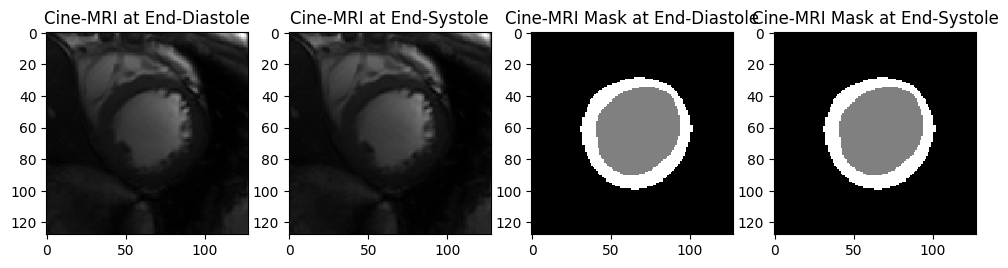

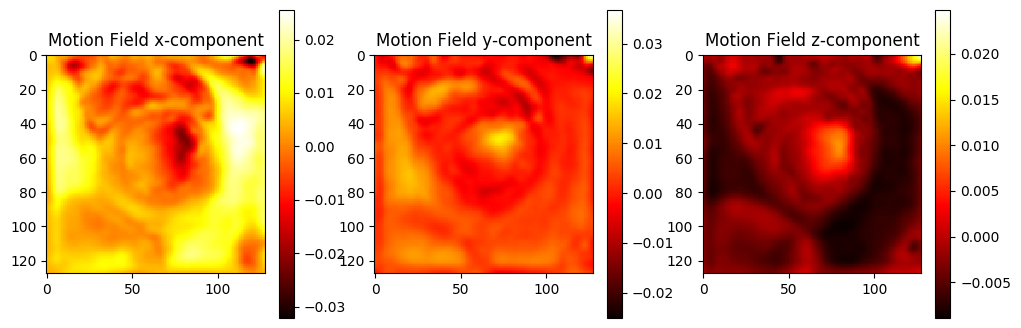

Radial strain:  -0.011092349020294136
Circumferential strain:  -0.005912061355113657
strain image:  (128, 128, 16)


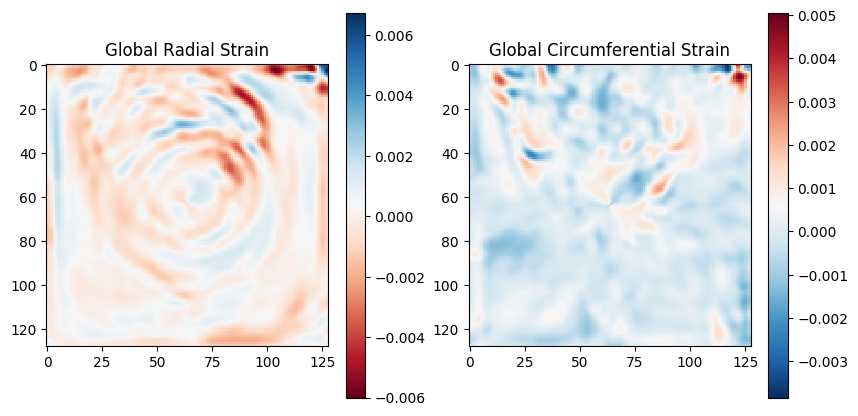

In [29]:
patient_id = 'ID_0002'

# save folder
strain_save_folder = os.path.join(main_path, 'results/trained/mvf', patient_id)
ff.make_folder([strain_save_folder])

# first: get the ED and ES frame
spreadsheet = pd.read_excel(os.path.join('/mnt/camca_NAS/HFpEF/data/HFpEF_data/', 'Patient_list', 'Important_HFpEF_Patient_list_unique_patient_w_ZCnotes.xlsx' ))
patient_id_num = ff.ID_00XX_to_XX(patient_id)
patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
ED = 0
ES = 0
print(ED,ES)

# second: load img and seg
patient_img_folder = os.path.join(data_path, patient_id,'img')
patient_seg_folder = os.path.join(data_path,  patient_id, 'seg')

V_nifti_ED = nb.load(os.path.join(patient_img_folder, 'img_tf' + str(ED) + '.nii.gz'))
V_nifti_ES = nb.load(os.path.join(patient_img_folder, 'img_tf' + str(ES) + '.nii.gz'))

M_nifti_ED = nb.load(os.path.join(patient_seg_folder, 'seg_tf' + str(ED) + '.nii.gz'))
M_nifti_ES = nb.load(os.path.join(patient_seg_folder, 'seg_tf' + str(ES) + '.nii.gz'))

# original pixel dim is
pixel_dim = V_nifti_ED.header.get_zooms()
print('original pixel dim is: ', pixel_dim)


# M_nifti_ED_RV = nb.load(os.path.join(main_path,'results/trained/seg/' ,patient_id,'pred_seg_frame' + str(ED) + '.nii.gz'))
# M_nifti_ES_RV = nb.load(os.path.join(main_path,'results/trained/seg/' ,patient_id,'pred_seg_frame' + str(ES) + '.nii.gz'))

# # third: preprocess - change the label in segmentation: RV = 1, Myocardium = 2, LV = 3
# M_ED = np.round(M_nifti_ED.get_fdata()).astype(int)
# M_ED_RV = np.round(M_nifti_ED_RV.get_fdata()).astype(int)
# new_M_ED = np.zeros_like(M_ED)
# new_M_ED[M_ED_RV==3] = 1
# new_M_ED[M_ED==1] = 3
# new_M_ED[M_ED==2] = 2
# M_nifti_ED = nb.Nifti1Image(new_M_ED, affine=M_nifti_ED.affine, header=M_nifti_ED.header)

# M_ES = np.round(M_nifti_ES.get_fdata()).astype(int)
# M_ES_RV = np.round(M_nifti_ES_RV.get_fdata()).astype(int)
# new_M_ES = np.zeros_like(M_ES)
# new_M_ES[M_ES_RV==3] = 1
# new_M_ES[M_ES==1] = 3
# new_M_ES[M_ES==2] = 2
# M_nifti_ES = nb.Nifti1Image(new_M_ES, affine=M_nifti_ES.affine, header=M_nifti_ES.header)

print('original shape: ',V_nifti_ED.get_fdata().shape, M_nifti_ED.get_fdata().shape, M_nifti_ES.get_fdata().shape)
print('original pixel dim is: ', V_nifti_ED.header.get_zooms())
print('labels: ', np.unique(M_nifti_ED.get_fdata()))


# fourth: prepare input
V_nifti = nb.funcs.concat_images((V_nifti_ED, V_nifti_ES))
M_nifti = nb.funcs.concat_images((M_nifti_ED, M_nifti_ES))
print('after concat, shape: ,', V_nifti.shape)

# data was trained with:
#  in-plane resolution of 1.25 mm x 1.25 mm
#  number of slices = 16
#  variable slice thickness since we specify number of slices
V_nifti = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
M_nifti = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)
print('after resample, shape: ', V_nifti.shape, M_nifti.shape)
print('pixel dim after reslice: ', V_nifti.header.get_zooms())

# calculate center of mass using the first frame as reference. This is needed for cropping to 128x128
center = center_of_mass(M_nifti.get_fdata()[:,:,:,0]==2) # RV = 1, Myocardium = 2, LV = 3
V = _roll2center_crop(x=V_nifti.get_fdata(), center=center)
M = _roll2center_crop(x=M_nifti.get_fdata(), center=center)
print('after crop, shape: ', V.shape, M.shape, ' Labels: ', np.unique(M))

plt.figure(figsize=(12,3))
plt.subplot(141); plt.imshow(V[:,:,7,0], cmap='gray'); plt.title('Cine-MRI at End-Diastole')
plt.subplot(142); plt.imshow(V[:,:,7,1], cmap='gray'); plt.title('Cine-MRI at End-Systole')
plt.subplot(143); plt.imshow(M[:,:,7,0], cmap='gray'); plt.title('Cine-MRI Mask at End-Diastole')
plt.subplot(144); plt.imshow(M[:,:,7,1], cmap='gray'); plt.title('Cine-MRI Mask at End-Systole')

# # 
V = ff.normalize_image(V)
nx, ny, nz, nt = V.shape
V_0 =  np.repeat(V[:,:,:,:1], nt-1, axis=-1)
V_t =  V[:,:,:,1:]

V_0 = np.transpose(V_0, (3,0,1,2))
V_t = np.transpose(V_t, (3,0,1,2))
print('before input into the model, the shape: ', V_0.shape, V_t.shape)

# fifth: predict motion vector
y_t = netME([V_0, V_t]).numpy()
# # or load saved motion vector
# y_t = nb.load(os.path.join(strain_save_folder, 'mvf_ED1_pair8.nii.gz')).get_fdata()
# y_t = y_t[None,...]
print('motion vector field shape: ', y_t.shape)

# smooth the motion fields. Note that these motion fields can be used to warp points individually, or could be 
# used to deform an endocardial contour. 
y_t = gaussian_filter(y_t, sigma=(0,2,2,0,0))

plt.figure(figsize=(12,4))
plt.subplot(131); plt.imshow(y_t[0,:,:,7,0], cmap='hot'); plt.title('Motion Field x-component'); plt.colorbar()
plt.subplot(132); plt.imshow(y_t[0,:,:,7,1], cmap='hot'); plt.title('Motion Field y-component'); plt.colorbar()
plt.subplot(133); plt.imshow(y_t[0,:,:,7,2], cmap='hot'); plt.title('Motion Field z-component'); plt.colorbar()
plt.show()

# a = nb.Nifti1Image(y_t[0,:,:,:,:] , affine=V_nifti_ED.affine, header=V_nifti_ED.header)
# nb.save(a, os.path.join(strain_save_folder, 'mvf.nii.gz'))

# # last: calculate strain 
mask_end_diastole = M[..., 0]
mask_end_systole = M[..., 1]
    
strain = myocardial_strain.MyocardialStrain(mask=mask_end_diastole, flow=y_t[0,:,:,:,:])
strain.calculate_strain(lv_label=2) # myolabel actually

print('Radial strain: ', 100*strain.Err[strain.mask_rot==2].mean())  # mask_rot means moves the whole mask (segmentation) to the center of myocardium
print('Circumferential strain: ', 100*strain.Ecc[strain.mask_rot==2].mean())
print('strain image: ', strain.Err.shape)

plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(strain.Err[:,:,7], cmap='RdBu'); plt.title('Global Radial Strain'); plt.colorbar()
plt.subplot(122); plt.imshow(strain.Ecc[:,:,7], cmap='RdBu_r'); plt.title('Global Circumferential Strain'); plt.colorbar()
plt.show() 
